In [25]:
# Import des librairies nécessaires
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, KFold, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.dummy import DummyRegressor

# Pour l'approche bayésienne
from skopt import gp_minimize
from skopt.space import Real, Integer

from lazypredict.Supervised import LazyRegressor

import shap


# Pour trouver les modèles les plus adaptés
from lazypredict.Supervised import LazyRegressor

In [2]:
sns.set()

In [26]:
def score(y_test, y_pred ) :
    "fonction pour calculer les performances du modele"
    
    MSE = mean_squared_error(y_test, y_pred).round(3)
    RMSE = np.sqrt(MSE).round(3)
    MAE = mean_absolute_error(y_test, y_pred).round(3)
    r2 = r2_score(y_test, y_pred).round(3).round(3)
    
    print(f'MSE : {MSE} || RMSE : {RMSE} || MAE : {MAE} || r² : {r2}')

In [4]:
def display_feat_imp_reg(reg):
    '''afficher l'importance des variables dans nos modèles'''

    feat_imp_reg = reg.coef_
    reg_feat_importance = pd.DataFrame(columns=["Feature Name", "Feature Importance"])
    reg_feat_importance["Feature Name"] = pd.Series(reg.feature_names_in_)
    reg_feat_importance["Feature Importance"] = pd.Series(feat_imp_reg)
    reg_feat_importance.plot.barh(y="Feature Importance", x="Feature Name", title="Feature importance", color="red")

In [5]:
def display_feat_imp_rforest(rforest, X_train):
    '''afficher l'importance des variables dans nos modèles de random forest'''
    feat_imp = rforest.feature_importances_
    df_featimp = pd.DataFrame(feat_imp, columns = {"Feature Importance"})
    df_featimp["Feature Name"] = X_train.columns
    df_featimp = df_featimp.sort_values(by="Feature Importance", ascending=False)
    print(df_featimp)
    df_featimp.plot.barh(y="Feature Importance", x="Feature Name", title="Feature importance", color="red")

In [6]:
def resultize(grid) : 
    '''Creation d'un dataframe contenant les hyperparametres des meilleurs résultats du grid search'''
    res = grid.cv_results_
    res = pd.DataFrame(res)
    cols = [i for i in res.columns if 'split' not in i]
    res = res[cols]
    res = res.sort_values('rank_test_score')
    
    return res

In [7]:
path = 'cleaned/'
filename = 'dataset_cleaned.csv'

In [8]:
df = pd.read_csv(path+filename)

In [9]:
path2 = 'cleaned/'
filename2 = 'dataset_cleaned2.csv'

In [10]:
# Utilisation du dataset original comprenant quelques modifications de nettoyage, pour pouvoir rajouter de nouvelles variables
data2 = pd.read_csv(path2+filename2)

In [138]:
df.head()

,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFABuilding(s),PropertyGFATotal,Electricity(kBtu),TotalGHGEmissions,GHGEmissionsIntensity,NaturalGas(kBtu),SiteEnergyUse(kBtu),SiteEUI(kBtu/sf),SourceEUI(kBtu/sf)
0,1927.00,1.00,2.72,88434.00,88434.00,3946027.00,249.98,2.83,1276453.00,7226362.50,81.70,182.50
1,1996.00,1.00,2.72,88502.00,103566.00,3242851.00,295.86,2.86,325617.00,8387933.00,94.80,176.10
2,1969.00,1.00,2.72,55045.34,58763.76,1363574.50,41.96,2.19,1493800.00,3618397.81,96.00,241.90
3,1926.00,1.00,2.72,61320.00,61320.00,2768924.00,286.43,0.75,1811213.00,6794584.00,110.80,216.20
4,1980.00,1.00,2.72,113580.00,175580.00,5368607.00,41.96,2.88,325617.00,14172606.00,114.80,211.40


### Emissions de CO2

#### Data preparation

In [11]:
# On supprime la 2eme target, qui est la consommation d'energy
df_CO2 = df.drop('SiteEnergyUse(kBtu)', axis = 1)

In [12]:
# On retire la target pour le X qui sera contenu dans Y
X1 = df_CO2.drop("TotalGHGEmissions", axis = 1)
y1 = df_CO2["TotalGHGEmissions"]

#### Validation croisée

In [13]:
# Création des modèles à tester
models = []
models.append(('LR', LinearRegression()))
models.append(('RF', RandomForestRegressor()))
models.append(('DRMean', DummyRegressor(strategy = 'mean')))
models.append(('DRMed',DummyRegressor(strategy = 'median')))

In [14]:
# Évaluation des modèles en utilisant la validation croisée
results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=10, random_state=42, shuffle=True)
    cv_results = cross_val_score(model, X1, y1, cv=kfold, scoring='neg_mean_squared_error')
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, -cv_results.mean(), cv_results.std())
    print(msg)

LR: 4509.740885 (987.600411)
RF: 5102.393141 (1032.510850)
DRMean: 4831.029606 (1034.115935)
DRMed: 5434.400162 (1342.837186)


En utilisant la validation croisée, on peut remarquer que le random forest semble être le modèle qui est le plus adapté dans ce cas.

In [15]:
# Separer le jeu de données en données d'entrainement et de test
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, test_size = 0.3, random_state = 42)

In [16]:
print(f'Nous avons X_train de forme {X_train1.shape} et y_train de forme {y_train1.shape}')
print(f'Nous avons X_test de forme {X_test1.shape} et y_test de forme {y_test1.shape}')

Nous avons X_train de forme (1059, 5) et y_train de forme (1059,)
Nous avons X_test de forme (454, 5) et y_test de forme (454,)


In [17]:
reg = LazyRegressor(predictions = True)
models_test,predictions_test = reg.fit(X_train1, X_test1, y_train1, y_test1) 
# Code qui va permettre de savoir quels algorithmes seront les mieux adaptés pour l'étude et la prédiction de notre jeu de données

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:20<00:00,  2.04it/s]


In [18]:
print(models_test)

                               Adjusted R-Squared  R-Squared     RMSE  \
Model                                                                   
ElasticNet                                   0.04       0.06    68.45   
TweedieRegressor                             0.04       0.05    68.47   
ElasticNetCV                                 0.04       0.05    68.59   
BayesianRidge                                0.04       0.05    68.69   
SGDRegressor                                 0.04       0.05    68.79   
Lasso                                        0.03       0.04    68.83   
RidgeCV                                      0.03       0.04    68.83   
LassoLarsCV                                  0.03       0.04    68.83   
LarsCV                                       0.03       0.04    68.83   
LassoCV                                      0.03       0.04    68.83   
Ridge                                        0.03       0.04    68.86   
LassoLarsIC                                  0.03  

On applique une validation croisée sur les données pour vérifier que le modèle a des comportements et comportements similaires sur chaque split.  
Si c'est pas le cas, on s'interessera à l'overfitting.

###### Validation croisée

In [19]:
# Instancier la regression lineaire
lr = LinearRegression()

In [20]:
# Cross validation pour observer si notre modele va overfitter
cv = KFold(n_splits=10, random_state=1, shuffle=True)
scores1 = cross_val_score(lr, X1, y1, cv=cv)
# Calcul du score
score1 = scores1.mean()
print('Score: %.3f (%.3f)' % (score1, scores1.std()))

Score: 0.063 (0.038)


On observe un score de 0.063% environ, ce qui n'est pas les meilleurs performances possibles, selon nous. .

### Modelisation 

#### Dummy regressor

In [21]:
# Appliquer un dummy regressor avec la strategie de la moyenne 
lm_dummy_mean1 = DummyRegressor(strategy = 'mean')
lm_dummy_mean1.fit(X_train1, y_train1)

# Appliquer un dummy regressor avec la strategie de la mediane 
lm_dummy_median1 = DummyRegressor(strategy = 'median')
lm_dummy_median1.fit(X_train1, y_train1)

DummyRegressor(strategy='median')

In [22]:
# Observer les données prédites à partir de nos modeles
y_pred_mean = lm_dummy_mean1.predict(X_test1)

y_pred_median = lm_dummy_median1.predict(X_test1)

In [23]:
print('prediction par rapport à la moyenne :',pd.Series(y_pred_mean).value_counts())
print('prediction par rapport à la mediane :',pd.Series(y_pred_median).value_counts())

prediction par rapport à la moyenne : 66.70    454
dtype: int64
prediction par rapport à la mediane : 41.96    454
dtype: int64


In [151]:
# Observation de la forme de la target
y_test1.values

array([178.86,  41.96,  32.09,  17.24, 158.92,   2.88,  41.96,  49.17,
        99.15,  24.62, 169.75, 267.  ,  53.57,  30.52,  61.6 ,   4.99,
         1.6 ,   8.8 ,  41.96,  38.57, 132.71,  46.01,   1.59,  76.68,
        41.96,  18.19,  75.29,  37.74,  16.13,   9.91,  41.96, 293.55,
         1.51,  44.22,  25.53,  61.53, 134.8 ,   3.06,   4.02,  33.1 ,
         9.67, 154.17,  20.64,  29.04,  13.14,  47.94,  41.96,  41.96,
         3.65,  41.96, 130.32, 282.46,  41.96, 166.13,  41.96,   5.17,
        27.97,  14.9 ,   8.47,  73.26, 171.64, 152.14,  40.01,  42.74,
       129.29,   6.73, 146.93,   6.3 , 167.98,   9.63,  61.98,  41.96,
        45.22,  30.49,  19.77, 133.58, 126.78,  17.29, 109.85, 243.66,
        19.28,  41.96,   2.64,  41.96,   3.93, 147.49,  11.14, 231.32,
         6.11,  67.51, 245.16,  18.03,  19.61,  31.74,  20.09,   6.88,
       106.86,  24.12,  31.24,   0.79, 184.6 , 133.8 ,  49.58,  17.6 ,
         8.85, 286.89,  49.98,  81.18, 144.79,  41.96,   2.28, 192.12,
      

In [27]:
score(y_test1,y_pred_mean)

MSE : 4959.626 || RMSE : 70.425 || MAE : 52.409 || r² : -0.0


In [28]:
score(y_test1,y_pred_median)

MSE : 5576.848 || RMSE : 74.678 || MAE : 45.804 || r² : -0.124


On a donc nos scores de base à partir desquels nous comparerons les scores de nos modèles pour voir si il est judicieux de les utiliser ou non. 

#### Regression lineaire 

In [29]:
# Appliquer la regression lineaire à nos données d'entrainement 
lr1 = LinearRegression()

lr1.fit(X_train1, y_train1)

LinearRegression()

In [30]:
# Observer les données prédites à partir de nos modeles
y_pred1 = lr1.predict(X_test1)

In [31]:
score(y_test1, y_pred1)

MSE : 4742.275 || RMSE : 68.864 || MAE : 51.21 || r² : 0.044


On observe des scores meilleurs que le dummy regressor, ce qui nous prouve que notre modèle apprend mieux que le modele de base dans ce cas là.

#### Standardisation 

In [32]:
scaler = StandardScaler()

# Normaliser notre jeu d'entrainement
normalized_X_train1 = pd.DataFrame(
    scaler.fit_transform(X_train1),
    columns = X_train1.columns
)

In [33]:
# Appliquer la regression lineaire à nos données normalisées
lr1_std = lr

lr1_std.fit(normalized_X_train1, y_train1)

LinearRegression()

In [34]:
# Normaliser le jeu de test avec les informations retenues de la premiere normalisation 
normalized_X_test1 = pd.DataFrame(
    scaler.transform(X_test1),
    columns = X_test1.columns
)

In [35]:
# Observer les données prédites
y_pred1_std = lr1_std.predict(normalized_X_test1)

In [36]:
score(y_test1, y_pred1_std)

MSE : 4742.275 || RMSE : 68.864 || MAE : 51.21 || r² : 0.044


La standardisation n'a pas l'air de changer les résultats dans ce cas là. 

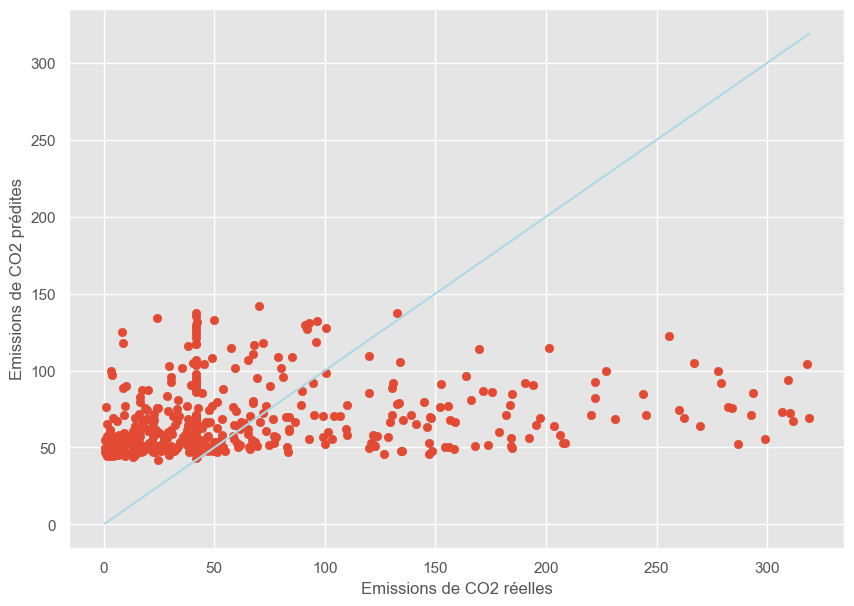

In [37]:
# Afficher les valeurs predites en comparaison avec les valeurs réelles 
plt.style.use('ggplot')
plt.figure(figsize=(10, 7))
plt.scatter(y_test1,y_pred1)
plt.plot([np.min(y_test1), np.max(y_test1)], [np.min(y_test1), np.max(y_test1)], color='lightblue')
plt.xlabel("Emissions de CO2 réelles")
plt.ylabel("Emissions de CO2 prédites")
plt.show()

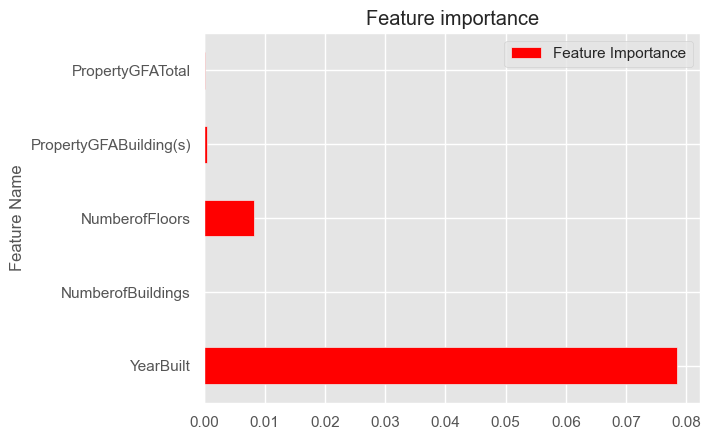

In [38]:
display_feat_imp_reg(lr1)

On voit que la variable qui a une très grand importance dans ce modele est l'année de construction du modèle. 

#### Random Forest

In [39]:
# Instancier le random forest
rf = RandomForestRegressor()

In [40]:
# Cross validation pour le random forest
scores3 = cross_val_score(rf, X1, y1, cv=cv)
# Calcul des scores
score3 = scores3.mean()
print('Score: %.3f (%.3f)' % (score3, scores3.std()))

Score: -0.028 (0.051)


On observe un score de -0.028, ce qui semble indiquer que le random forest semble apprendre moins bien que la regression lineaire dans ce cas là.

In [41]:
# On instancie le modele et on l'entraine avec les hyper-paramètres de base
rf1 = rf
rf1.fit(X_train1, y_train1)

RandomForestRegressor()

In [42]:
# On regarde les prédictions 
y_pred2 = rf1.predict(X_test1)

In [43]:
score(y_test1, y_pred2)

MSE : 5340.459 || RMSE : 73.078 || MAE : 52.98 || r² : -0.077


On observe de meilleurs résultats que avec la regression lineaire, ce qui vient confirmer notre hypothèse de la cross validation.

#### Standardisation

In [44]:
# Instancier le modele
rf1_std = rf

# Entrainer le modele avec les données normalisées
rf1_std.fit(normalized_X_train1, y_train1)

# Calculer les prédictions
y_pred2_std = rf1_std.predict(normalized_X_test1)

In [45]:
score(y_test1, y_pred2_std)

MSE : 5290.285 || RMSE : 72.734 || MAE : 52.697 || r² : -0.067


La standardisation des données n'améliore que légerement les performances du modele.

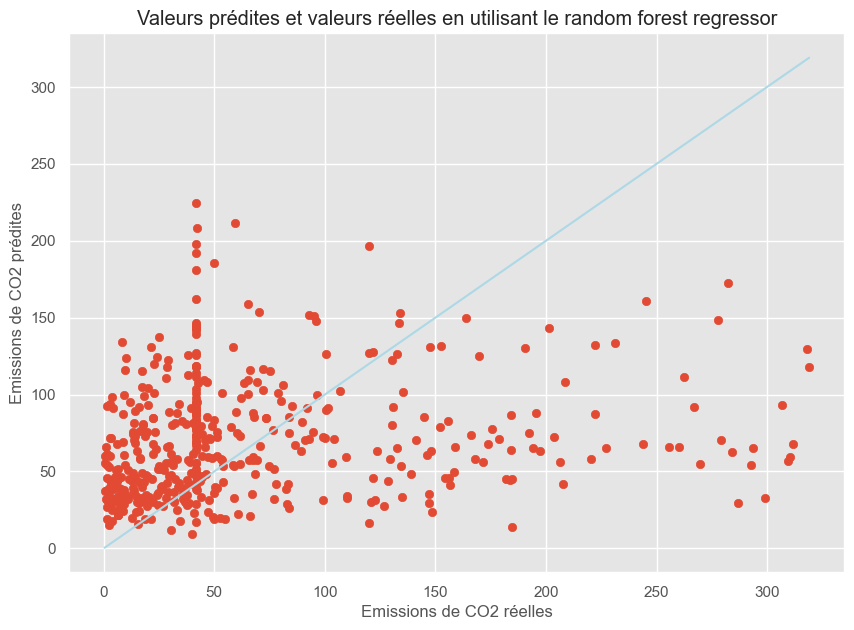

In [46]:
# Afficher les valeurs predites en comparaison avec les valeurs réelles 
plt.style.use('ggplot')
plt.figure(figsize=(10, 7))
plt.scatter(y_test1,y_pred2)
plt.plot([np.min(y_test1), np.max(y_test1)], [np.min(y_test1), np.max(y_test1)], color='lightblue')
plt.xlabel("Emissions de CO2 réelles")
plt.ylabel("Emissions de CO2 prédites")
plt.title("Valeurs prédites et valeurs réelles en utilisant le random forest regressor")
plt.show()

   Feature Importance            Feature Name
3                0.34  PropertyGFABuilding(s)
0                0.29               YearBuilt
4                0.25        PropertyGFATotal
2                0.11          NumberofFloors
1                0.00       NumberofBuildings


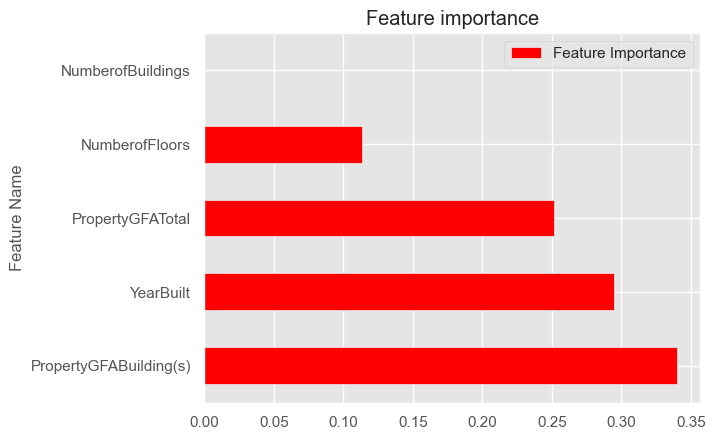

In [47]:
display_feat_imp_rforest(rf1, X_train1)

Dans ce cas là, on voit que les variables avec le plus d'importance pour le modele ne sont pas exactement les mêmes que pour la regression.  
En effet, on notera l'intensité de consommation d'energie, les intensités des emissions de GES mais egalement la quantité annuelle de gaz consommée par la propriété.

### Trouver les hyper-paramètres

Les hyper-paramètres sont des paramètres des modèles qui vont servir à améliorer la qualité des performances de nos modèles, lorsqu'ils sont bien choisi.

#### Regression lineaire

In [48]:
lr2 = lr

In [49]:
# Créer une grille de paramètre pour la regression lineaire
param_grid = {'normalize': [True, False],
              'fit_intercept': [True, False],
              'copy_X': [True, False]}

In [50]:
# Instancier le grid search et l'entraîner
grid = GridSearchCV(lr2, param_grid, cv = 5, return_train_score = True)

grid.fit(X_train1, y_train1)

GridSearchCV(cv=5, estimator=LinearRegression(),
             param_grid={'copy_X': [True, False],
                         'fit_intercept': [True, False],
                         'normalize': [True, False]},
             return_train_score=True)

In [51]:
# Affichage des hyperparametres optimaux
best_params = grid.best_params_
best_params

{'copy_X': True, 'fit_intercept': True, 'normalize': False}

In [52]:
resultize(grid).head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_copy_X,param_fit_intercept,param_normalize,params,mean_test_score,std_test_score,rank_test_score,mean_train_score,std_train_score
1,0.00,0.00,0.00,0.00,True,True,False,"{'copy_X': True, 'fit_intercept': True, 'norma...",0.07,0.03,1,0.08,0.01
5,0.00,0.00,0.00,0.00,False,True,False,"{'copy_X': False, 'fit_intercept': True, 'norm...",0.07,0.03,1,-7.53,3.00
0,0.00,0.00,0.00,0.00,True,True,True,"{'copy_X': True, 'fit_intercept': True, 'norma...",0.07,0.03,3,0.08,0.01
4,0.00,0.00,0.00,0.00,False,True,True,"{'copy_X': False, 'fit_intercept': True, 'norm...",0.07,0.03,3,-7.62,3.00
2,0.00,0.00,0.00,0.00,True,False,True,"{'copy_X': True, 'fit_intercept': False, 'norm...",0.07,0.03,5,0.08,0.01
3,0.00,0.00,0.00,0.00,True,False,False,"{'copy_X': True, 'fit_intercept': False, 'norm...",0.07,0.03,5,0.08,0.01
6,0.00,0.00,0.00,0.00,False,False,True,"{'copy_X': False, 'fit_intercept': False, 'nor...",0.07,0.03,5,0.08,0.01
7,0.00,0.00,0.00,0.00,False,False,False,"{'copy_X': False, 'fit_intercept': False, 'nor...",0.07,0.03,5,0.08,0.01


In [53]:
# On instancie la regression lineaire avec les meilleurs parametres puis on entraine nos données avec ce modele
lr2 = LinearRegression(**best_params)
lr2.fit(X_train1, y_train1)
y_pred1_bis = lr2.predict(X_test1)

In [54]:
score(y_test1, y_pred1_bis)

MSE : 4742.275 || RMSE : 68.864 || MAE : 51.21 || r² : 0.044


On remarque que le tuning des hyper parametres dans le cas de la regression lineaire n'a pas apporté plus de précision que l'entrainement du modele de base

#### Random forest

In [55]:
rf2 = rf

In [56]:
# On definit les paramètres 
param_grid = {'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [5,10,15]}

In [57]:
# Instancier le grid search et l'entraîner
grid = GridSearchCV(rf2, param_grid, cv = 5, return_train_score = True)

grid.fit(X_train1, y_train1)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'max_depth': [5, 10, 15],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [200, 500]},
             return_train_score=True)

In [58]:
# Affichage des hyperparametres optimaux
best_params = grid.best_params_
best_params

{'max_depth': 5, 'max_features': 'sqrt', 'n_estimators': 200}

In [59]:
resultize(grid).head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_features,param_n_estimators,params,mean_test_score,std_test_score,rank_test_score,mean_train_score,std_train_score
2,0.22,0.00,0.02,0.00,5,sqrt,200,"{'max_depth': 5, 'max_features': 'sqrt', 'n_es...",0.10,0.02,1,0.28,0.01
3,0.58,0.02,0.04,0.00,5,sqrt,500,"{'max_depth': 5, 'max_features': 'sqrt', 'n_es...",0.10,0.02,2,0.28,0.01
5,0.58,0.02,0.04,0.00,5,log2,500,"{'max_depth': 5, 'max_features': 'log2', 'n_es...",0.10,0.02,3,0.28,0.01
4,0.28,0.01,0.02,0.00,5,log2,200,"{'max_depth': 5, 'max_features': 'log2', 'n_es...",0.10,0.02,4,0.29,0.01
1,0.71,0.01,0.04,0.00,5,auto,500,"{'max_depth': 5, 'max_features': 'auto', 'n_es...",0.09,0.02,5,0.30,0.02


In [60]:
# On instancie le random forest avec les meilleurs parametres puis on entraine nos données avec ce modele
rf2 = RandomForestRegressor(**best_params)
rf2.fit(X_train1, y_train1)
y_pred2_bis = rf2.predict(X_test1)

In [61]:
score(y_test1, y_pred2_bis)

MSE : 4587.958 || RMSE : 67.734 || MAE : 49.972 || r² : 0.075


###### random search

In [62]:
# On definit les paramètres  
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]

In [63]:
# On instancie notre liste de parametre
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

In [64]:
# On instancie notre random search et on l'entraine sur nos données
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
rf_random.fit(X_train1, y_train1)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [65]:
# Affichage des hyperparametres optimaux
best_params = rf_random.best_params_
best_params

{'n_estimators': 1000,
 'min_samples_split': 10,
 'min_samples_leaf': 4,
 'max_features': 'sqrt',
 'max_depth': 20}

In [66]:
# On instancie le random forest avec les meilleurs parametres puis on entraine nos données avec ce modele
rf2_random = RandomForestRegressor(**best_params)
rf2_random.fit(X_train1, y_train1)
y_pred2_random = rf2_random.predict(X_test1)

In [67]:
score(y_test1, y_pred2_random)

MSE : 4676.259 || RMSE : 68.383 || MAE : 50.062 || r² : 0.057


On remarque que le random search améliore les performances de notre modèle.  
Nous testerons également une approche bayésienne. 

##### Approche Bayésienne 

In [68]:
# Definir une fonction qui va permettre de minimiser le RMSE pour l'optimisation bayésienne
def objective(params):
    n_estimators = params[0]
    max_depth = params[1]
    min_samples_split = params[2]
    min_samples_leaf = params[3]

    randomF = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth,
                                min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf,
                                random_state=42)
    rmse = -cross_val_score(randomF, X1, y1, scoring='neg_root_mean_squared_error', cv=5).mean()
    return rmse

In [69]:
# Définir l'espace de recherche pour les hyperparamètres
space = [Integer(10, 500, name='n_estimators'),
         Integer(1, 20, name='max_depth'),
         Integer(2, 20, name='min_samples_split'),
         Integer(1, 20, name='min_samples_leaf')]

In [70]:
# Nombre d'itération
n_it = 50

In [71]:
# Lancer l'optimisation bayésienne 
result = gp_minimize(objective, space, n_calls=n_it, random_state=42, n_jobs=-1)

In [72]:
# Afficher les meilleurs hyperparamètres
best_n_estimators = result.x[0]
best_max_depth = result.x[1]
best_min_samples_split = result.x[2]
best_min_samples_leaf = result.x[3]
best_rmse = -result.fun

print(f"Best n_estimators: {best_n_estimators}")
print(f"Best max_depth: {best_max_depth}")
print(f"Best min_samples_split: {best_min_samples_split}")
print(f"Best min_samples_leaf: {best_min_samples_leaf}")
print(f"Best RMSE: {best_rmse}")

Best n_estimators: 437
Best max_depth: 3
Best min_samples_split: 2
Best min_samples_leaf: 20
Best RMSE: -65.19476160499487


In [73]:
# Entraîner un random forest regressor avec les meilleurs hyperparamètre
rf_by = RandomForestRegressor(n_estimators=best_n_estimators, max_depth=best_max_depth,
                            min_samples_split=best_min_samples_split, min_samples_leaf=best_min_samples_leaf,
                            random_state=42)
rf_by.fit(X_train1, y_train1)


y_pred2_by = rf_by.predict(X_test1)
test_rmse = mean_squared_error(y_test1, y_pred2_by, squared=False)

print(f"Test RMSE: {test_rmse}")

Test RMSE: 67.39075644472156


In [74]:
score(y_test1, y_pred2_by)

MSE : 4541.514 || RMSE : 67.391 || MAE : 49.805 || r² : 0.084


On remarque que l'approche bayésienne améliore les résultats de notre modèle, on retiendra cette méthode avec ce modèle. 

   Feature Importance            Feature Name
3                0.71  PropertyGFABuilding(s)
4                0.15        PropertyGFATotal
2                0.07          NumberofFloors
0                0.06               YearBuilt
1                0.00       NumberofBuildings


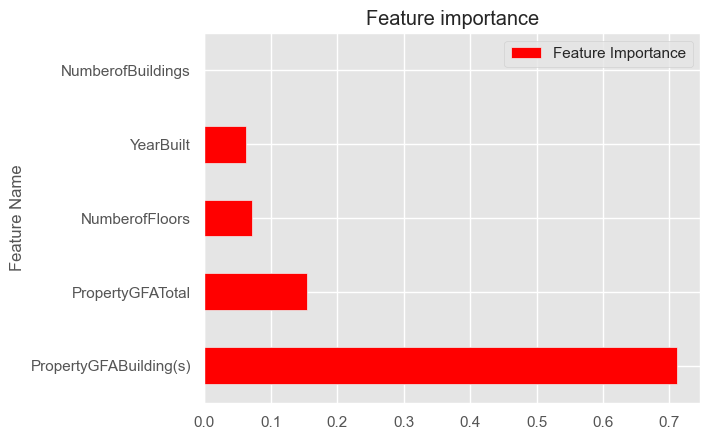

In [75]:
display_feat_imp_rforest(rf_by, X_train1)

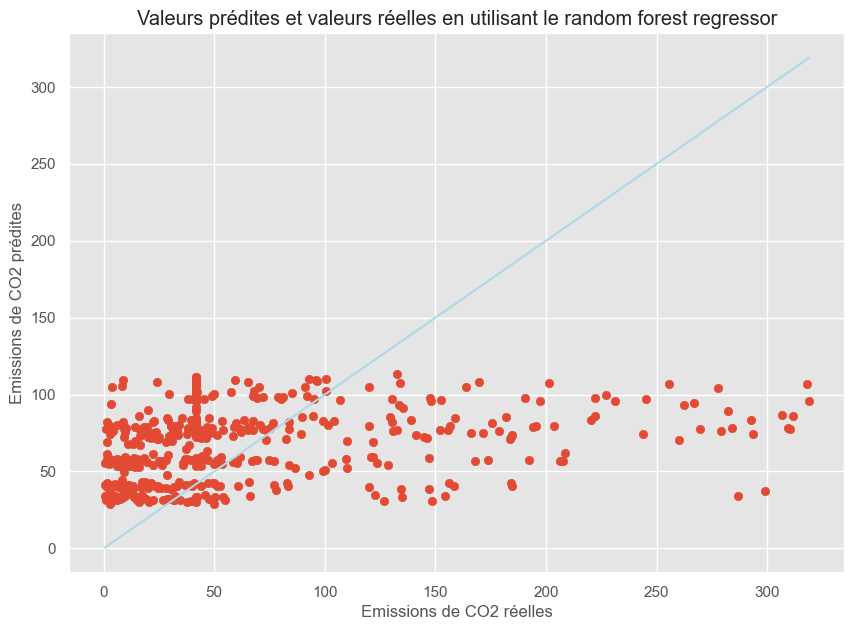

In [76]:
# Afficher les valeurs predites en comparaison avec les valeurs réelles 
plt.style.use('ggplot')
plt.figure(figsize=(10, 7))
plt.scatter(y_test1,y_pred2_by)
plt.plot([np.min(y_test1), np.max(y_test1)], [np.min(y_test1), np.max(y_test1)], color='lightblue')
plt.xlabel("Emissions de CO2 réelles")
plt.ylabel("Emissions de CO2 prédites")
plt.title("Valeurs prédites et valeurs réelles en utilisant le random forest regressor")
plt.show()

### Ajout de variables catégorielles 

In [77]:
data_enc = data2.copy()

##### Emissions de CO2

In [78]:
# On supprime la 2eme target, qui est la conso d'energy
df_CO2_2 = data_enc.drop('SiteEnergyUse(kBtu)', axis = 1)

In [79]:
# On retire la target pour le X qui sera contenu dans Y
X3 = df_CO2_2.drop("TotalGHGEmissions", axis = 1)
y3 = df_CO2_2["TotalGHGEmissions"]

#### Validation croisée

In [80]:
# Cross validation
scores5 = cross_val_score(lr, X3, y3, cv=cv)
# Calcul des scores
score5 = scores5.mean()
print('Score: %.3f (%.3f)' % (score5, scores5.std()))

Score: 0.085 (0.043)


On observe pas vraiment d'amélioration avec les variables catégorielles.

In [81]:
# Separer le jeu de données en données d'entrainement et de test
X_train3, X_test3, y_train3, y_test3 = train_test_split(X3, y3, test_size = 0.3, random_state = 42)

In [82]:
print(f'Nous avons X_train de forme {X_train3.shape} et y_train de forme {y_train3.shape}')
print(f'Nous avons X_test de forme {X_test3.shape} et y_test de forme {y_test3.shape}')

Nous avons X_train de forme (1059, 7) et y_train de forme (1059,)
Nous avons X_test de forme (455, 7) et y_test de forme (455,)


#### Regression lineaire

In [83]:
# Appliquer la regression lineaire à nos données d'entrainement 
lr5 = lr

lr5.fit(X_train3, y_train3)

LinearRegression()

In [84]:
# Observer les données prédites à partir de nos modeles
y_pred5 = lr5.predict(X_test3)

In [85]:
score(y_test3, y_pred5)

MSE : 4688.007 || RMSE : 68.469 || MAE : 49.391 || r² : 0.044


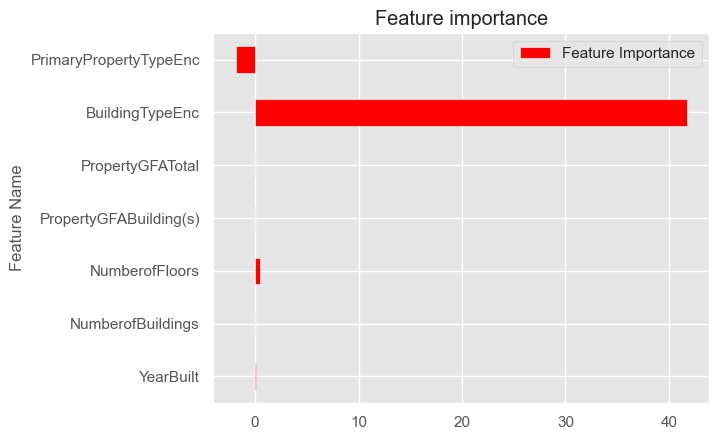

In [86]:
display_feat_imp_reg(lr5)

On observe que la regression lineaire améliore legerement lorsqu'on ajoute des variables catégorielles.  
On observe que le type de batiment (nouvelle variable) a une très forte importance dans le modele.

#### Random Forest

In [87]:
# Cross validation pour le random forest
scores7 = cross_val_score(rf, X3, y3, cv=cv)
# Calcul des scores
score7 = scores7.mean()
print('Score: %.3f (%.3f)' % (score7, scores7.std()))

Score: 0.089 (0.109)


On observe une legère diminution du score avec les variables catégorielles.

In [88]:
# On instancie le modele et on l'entraine avec les hyper-paramètres de base
rf5 = rf
rf5.fit(X_train3, y_train3)

RandomForestRegressor()

In [89]:
# On regarde les prédictions 
y_pred6 = rf5.predict(X_test3)

In [90]:
score(y_test3, y_pred6)

MSE : 4669.456 || RMSE : 68.333 || MAE : 48.671 || r² : 0.048


   Feature Importance            Feature Name
3                0.25  PropertyGFABuilding(s)
0                0.25               YearBuilt
4                0.21        PropertyGFATotal
6                0.18  PrimaryPropertyTypeEnc
2                0.08          NumberofFloors
5                0.03         BuildingTypeEnc
1                0.00       NumberofBuildings


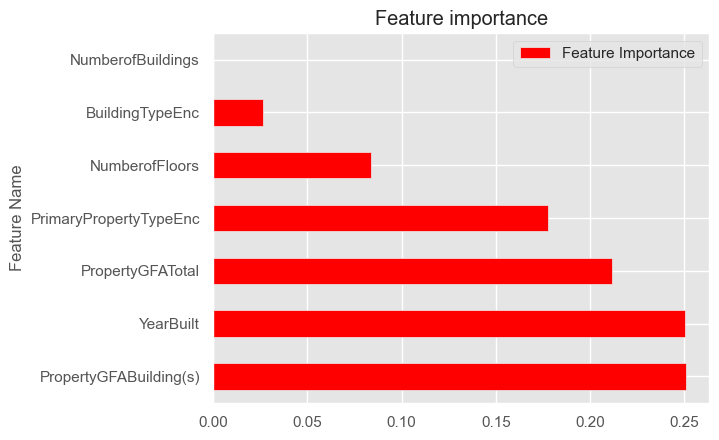

In [91]:
display_feat_imp_rforest(rf5, X_train3)

On observe une augmentation des scores en utilisant les variables catégorielles dans le cas du random forest, lorsque la target sont les emissions de CO2.

### Trouver les hyper-paramètres

#### Regression lineaire

In [97]:
lr6 = lr

In [98]:
# Créer une grille de paramètre pour la regression lineaire
param_grid = {'normalize': [True, False],
              'fit_intercept': [True, False],
              'copy_X': [True, False]}

In [99]:
# Instancier le grid search et l'entraîner
grid = GridSearchCV(lr6, param_grid, cv = 5, return_train_score = True)

grid.fit(X_train3, y_train3)

GridSearchCV(cv=5, estimator=LinearRegression(),
             param_grid={'copy_X': [True, False],
                         'fit_intercept': [True, False],
                         'normalize': [True, False]},
             return_train_score=True)

In [100]:
# Affichage des hyperparametres optimaux
best_params = grid.best_params_
best_params

{'copy_X': True, 'fit_intercept': True, 'normalize': False}

In [101]:
# On instancie la regression lineaire avec les meilleurs parametres puis on entraine nos données avec ce modele
lr6 = LinearRegression(**best_params)
lr6.fit(X_train3, y_train3)
y_pred5_bis = lr6.predict(X_test3)

In [102]:
score(y_test3, y_pred5_bis)

MSE : 4688.007 || RMSE : 68.469 || MAE : 49.391 || r² : 0.044


Pas de changement

#### Random forest

###### random search

In [103]:
rf6 = rf

In [104]:
# On definit les paramètres  
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]

In [105]:
# On instancie notre liste de parametre
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

In [106]:
# On instancie notre random search et on l'entraine sur nos données
rf_random2 = RandomizedSearchCV(estimator = rf6, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
rf_random2.fit(X_train3, y_train3)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [107]:
# Affichage des hyperparametres optimaux
best_params = rf_random2.best_params_
best_params

{'n_estimators': 1000,
 'min_samples_split': 10,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 90}

In [108]:
# On instancie le random forest avec les meilleurs parametres puis on entraine nos données avec ce modele
rf6_random = RandomForestRegressor(**best_params)
rf6_random.fit(X_train3, y_train3)
y_pred6_random = rf6_random.predict(X_test3)

In [109]:
score(y_test3, y_pred6_random)

MSE : 4247.445 || RMSE : 65.172 || MAE : 46.662 || r² : 0.134


On remarque que le random search améliore grandement les performances de notre modèle.    
Nous testerons une approche bayésienne. 

#### Approche bayésienne 

In [110]:
# Definir une fonction qui va permettre de minimiser le RMSE pour l'optimisation bayésienne
def objective2(params):
    n_estimators = params[0]
    max_depth = params[1]
    min_samples_split = params[2]
    min_samples_leaf = params[3]

    randomF = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth,
                                min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf,
                                random_state=42)
    rmse = -cross_val_score(randomF, X3, y3, scoring='neg_root_mean_squared_error', cv=5).mean()
    return rmse

In [111]:
# Lancer l'optimisation bayésienne 

result2 = gp_minimize(objective2, space, n_calls=n_it, random_state=42, n_jobs=-1)

In [112]:
# Afficher les meilleurs hyperparamètres
best_n_estimators = result2.x[0]
best_max_depth = result2.x[1]
best_min_samples_split = result2.x[2]
best_min_samples_leaf = result2.x[3]
best_rmse = -result2.fun

print(f"Best n_estimators: {best_n_estimators}")
print(f"Best max_depth: {best_max_depth}")
print(f"Best min_samples_split: {best_min_samples_split}")
print(f"Best min_samples_leaf: {best_min_samples_leaf}")
print(f"Best RMSE: {best_rmse}")

Best n_estimators: 500
Best max_depth: 8
Best min_samples_split: 13
Best min_samples_leaf: 2
Best RMSE: -63.50072633783667


In [113]:
# Entraîner un random forest regressor avec les meilleurs hyperparamètre
rf_by2 = RandomForestRegressor(n_estimators=best_n_estimators, max_depth=best_max_depth,
                            min_samples_split=best_min_samples_split, min_samples_leaf=best_min_samples_leaf,
                            random_state=42)
rf_by2.fit(X_train3, y_train3)

y_pred6_by = rf_by2.predict(X_test3)

test_rmse = mean_squared_error(y_test3, y_pred6_by, squared=False)

print(f"Test RMSE: {test_rmse}")

Test RMSE: 66.04286090831597


In [114]:
score(y_test3, y_pred6_by)

MSE : 4361.659 || RMSE : 66.043 || MAE : 47.125 || r² : 0.111


On observe de meilleurs résultats avec l'approche du random search.

On observe également de meilleurs résultats lorsqu'on ajoute les variables catégorielles. 

   Feature Importance            Feature Name
3                0.25  PropertyGFABuilding(s)
4                0.24        PropertyGFATotal
6                0.21  PrimaryPropertyTypeEnc
0                0.19               YearBuilt
2                0.09          NumberofFloors
5                0.03         BuildingTypeEnc
1                0.00       NumberofBuildings


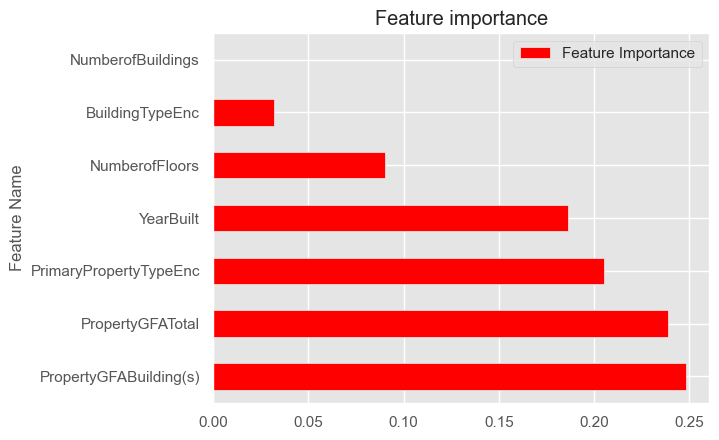

In [123]:
display_feat_imp_rforest(rf6_random, X_train3)

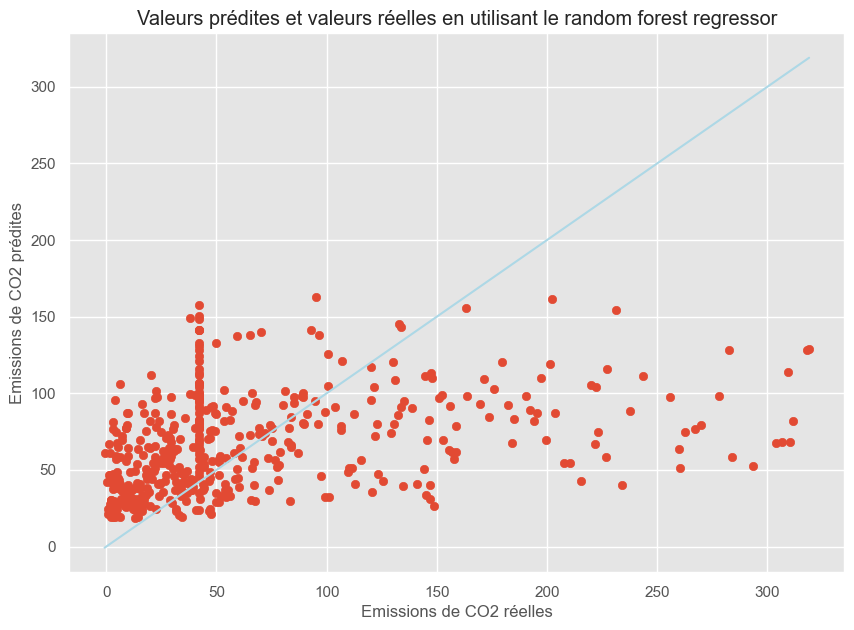

In [124]:
# Afficher les valeurs predites en comparaison avec les valeurs réelles 
plt.style.use('ggplot')
plt.figure(figsize=(10, 7))
plt.scatter(y_test3,y_pred6_random)
plt.plot([np.min(y_test3), np.max(y_test3)], [np.min(y_test3), np.max(y_test3)], color='lightblue')
plt.xlabel("Emissions de CO2 réelles")
plt.ylabel("Emissions de CO2 prédites")
plt.title("Valeurs prédites et valeurs réelles en utilisant le random forest regressor")
plt.show()

sans variables catégorielles : bayesienne  
avec : random search

### Pour les émissions de CO2, on remarque que les données catégorielles améliorent les performances du Random Forest.  
### On gardera le random forest car c'est avec cet algorithme qu'on a les meilleurs résultats en optimisant ses paramètres à l'aide d'un random search. 

## SHAP

On s'interesse à l'importance des variables, on commencera par la méthode SHAP.  
On prend en compte le modele de random forest avec variable catégorielle car c'est celui qui a donné les meilleurs résultats dans ce cas.  
On utilisera également les résultats de l'approche bayésienne qui nous a permit d'améliorer les performances du modèle.

In [125]:
rf_regressor1 = shap.TreeExplainer(rf6_random, X_train3)

In [126]:
shap_vals = rf_regressor1.shap_values(X_test3.iloc[0])
print("Expected/Base Value : ", rf_regressor1.expected_value)
print()
print("Shap Values for Sample 0 : ", shap_vals)
print("\n")
print("Prediction From Model                            : ", rf6_random.predict(np.array(X_test3.iloc[0]).reshape(1,-1))[0])
print("Prediction From Adding SHAP Values to Base Value : ", rf_regressor1.expected_value + shap_vals.sum())

Expected/Base Value :  64.54116475059168

Shap Values for Sample 0 :  [-1.64316388  0.         -5.91014315 12.7517166   8.19694866 -0.70429226
 -0.08879789]


Prediction From Model                            :  77.14343282249577
Prediction From Adding SHAP Values to Base Value :  77.14343282964616


In [127]:
# Calculer les valeurs shap de notre modele de random forest 
shap_values = rf_regressor1.shap_values(X_test3, check_additivity=False)

# contribution moyenne de chaque variable à chaque prédiction pour chaque instance sur la base de toutes les configurations de variables possibles

 99%|===================| 449/455 [01:03<00:00]        

In [128]:
shap_values

array([[ -1.64316388,   0.        ,  -5.91014315, ...,   8.19694866,
         -0.70429226,  -0.08879789],
       [ 17.83573471,   0.        ,  16.19232975, ...,  15.80453714,
         -0.92918191,  22.90334417],
       [  5.0821135 ,   0.        ,   4.4769456 , ...,   8.31147298,
         -0.98696588,   9.24956105],
       ...,
       [  0.78251459,   0.        ,   2.43862868, ...,   6.53046952,
         -0.97893368,  -8.24047386],
       [  1.94920279,   0.        ,  -4.33639442, ...,  -5.07013675,
         -0.97150467, -11.38026327],
       [  0.39715262,   0.        ,   4.71737236, ...,   5.8326341 ,
         -0.66111641,   8.68216313]])

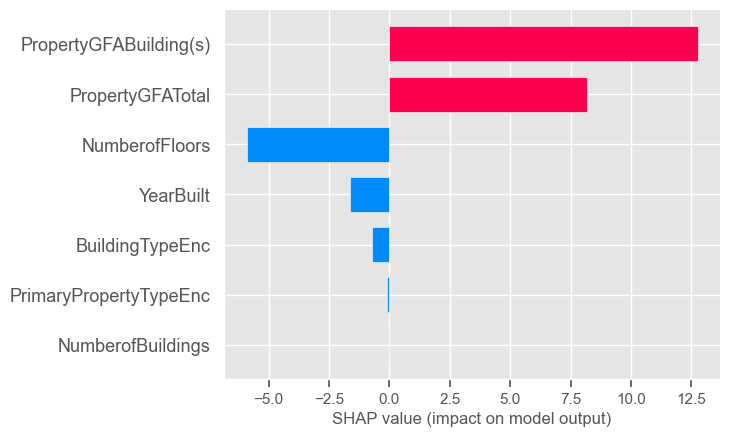

In [129]:
shap.bar_plot(shap_values[0],
              feature_names=X3.columns,
              max_display=len(X3.columns))

On voit que, **pour cet echantillon de données**, les variables suivantes contribuent positivement pour la prédication finale : **PropertyGFABuilding(s), PropertyGFATotal** .  
Au contraire, on voit que les variables suivantes contribuent négativement pour la prédiction finale : **NumberofFloors, YearBuilt et BuildingTypeEnc**.

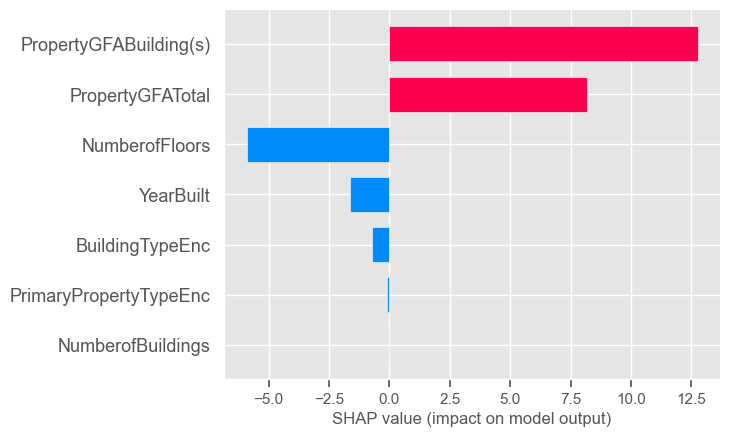

In [130]:
# Realisation d'un graphique a barre à partir du premier explicateur
shap.bar_plot(rf_regressor1.shap_values(X_test3.iloc[0]),
              feature_names=X3.columns,
              max_display=len(X3.columns))

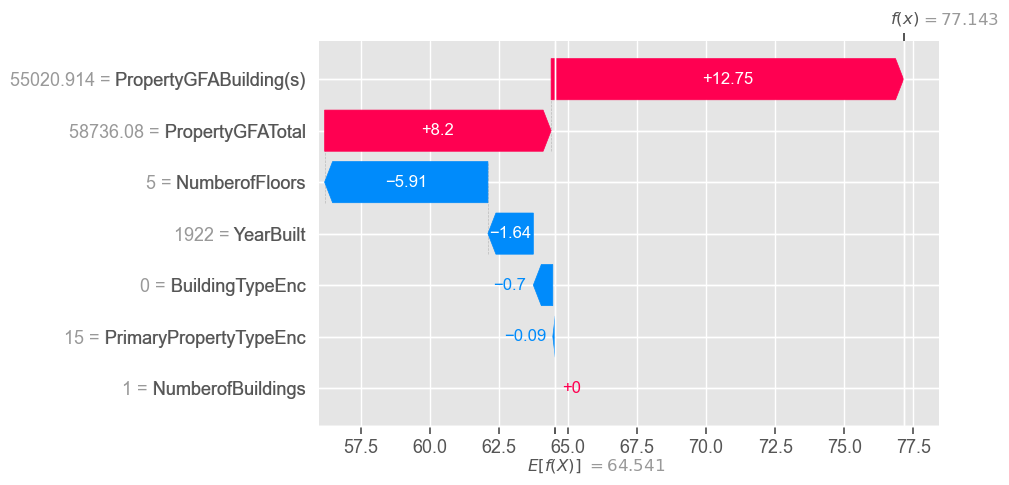

In [131]:
# Waterfall plot pour le premier objet explicatif qui ne tient pas compte de l'interaction entre les objets 

shap_values2 = rf_regressor1(X_test3[:1])
shap.waterfall_plot(shap_values2[0], max_display=len(df_CO2_2.columns))

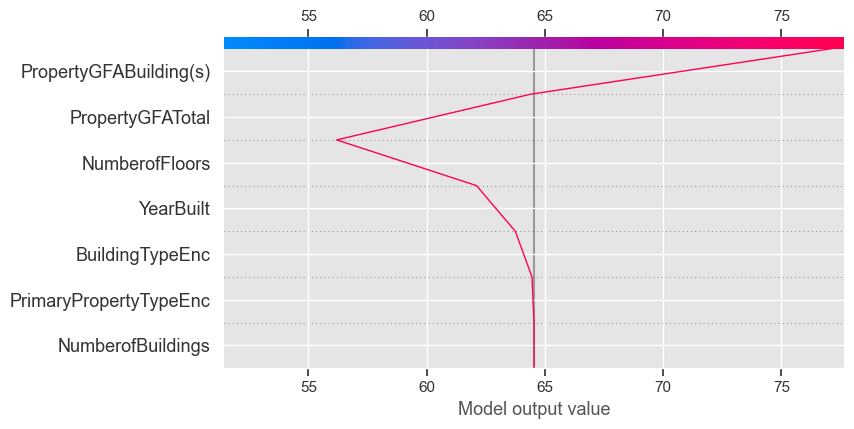

In [132]:
# Diagramme de décision d'un échantillon unique à partir de l'ensemble de données de test en utilisant le premier explicateur de notre random forest
shap.decision_plot(rf_regressor1.expected_value,
                   rf_regressor1.shap_values(X_test3.iloc[0]),
                   feature_names=X3.columns.tolist(),
                   )

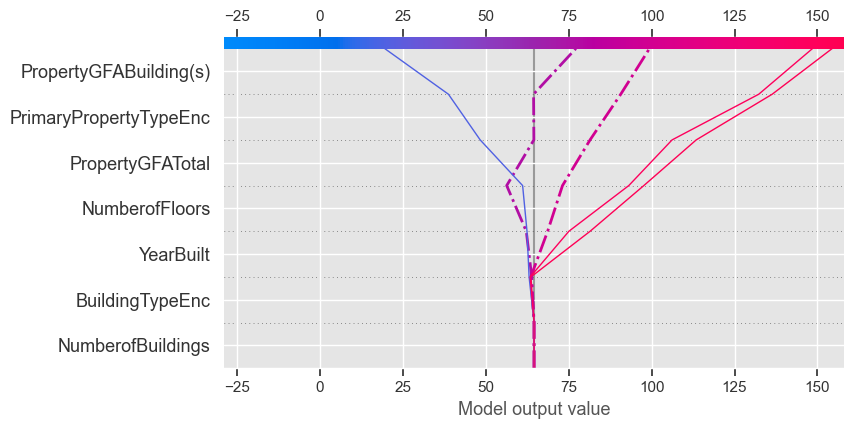

In [133]:
# diagramme de décision de 5 échantillons à partir de l'ensemble de données de test en utilisant le premier explicateur du random forest 
shap.decision_plot(rf_regressor1.expected_value,
                   rf_regressor1.shap_values(X_test3.iloc[0:5]),
                   feature_names=X3.columns.tolist(),
                   highlight=[0, 2],
                   )

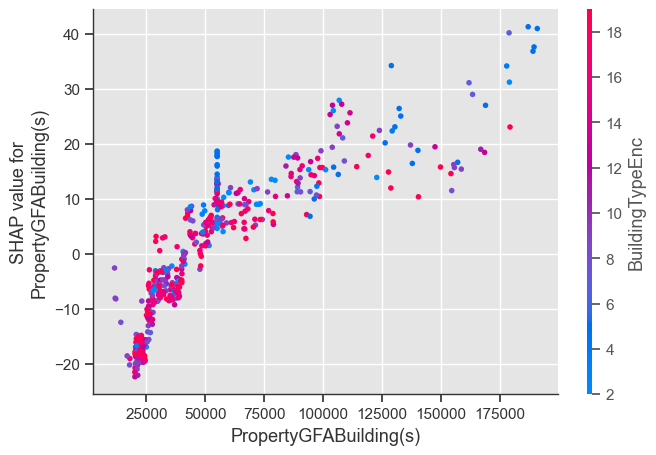

In [135]:
# Montrer la relation entre les valeurs réelles et les valeurs shap pour une variable particulière
shap.dependence_plot("PropertyGFABuilding(s)",
                     shap_values,
                     features=X_test3,
                     feature_names=df_CO2_2.columns,
                     )

Nous avons réalisé ce travail pour la variable PropertyGFABuilding(s) et cela nous montre aussi l'interaction avec la variable BuildingTypeEnc.

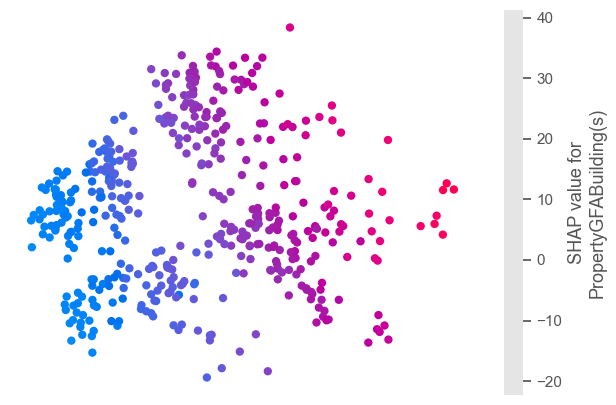

In [136]:
# Répartition des différentes valeurs de forme pour une caractéristique particulière
shap.embedding_plot("PropertyGFABuilding(s)",
                    shap_values,
                    feature_names=df_CO2_2.columns)

In [137]:
# Montrer quelles variables ont contribué pour les prédictions finales et de quelle façon
shap.initjs()
shap.force_plot(rf_regressor1.expected_value,
                rf_regressor1.shap_values(X_test3.iloc[0]),
                feature_names=X3.columns.tolist(),
                out_names="emissions "
               )

In [138]:
# force plot de 10 échantillons de l'ensemble de données en utilisant notre explicateur.
shap.force_plot(rf_regressor1.expected_value,
                rf_regressor1.shap_values(X_test3.iloc[0:10]),
                feature_names=X3.columns.tolist(),
                out_names="emissions", figsize=(25,3),
                link="identity")

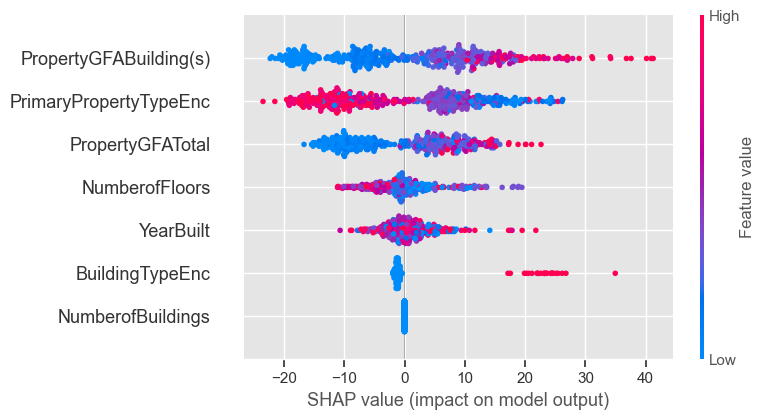

In [139]:
# distribution des valeurs de forme pour toutes les caractéristiques des données
shap.summary_plot(shap_values,
                  features = X_test3,
                  feature_names=X3.columns.tolist())

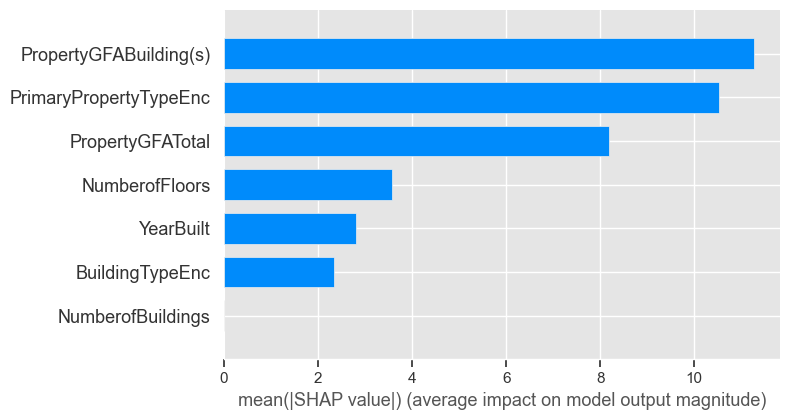

In [140]:
# impact moyen de chaque variable sur la prédiction finale et feature importance
shap_values_summary = shap.summary_plot(shap_values,feature_names=X3.columns.tolist(), plot_type='bar')

Ces 2 plot permettent de voir les variables les plus importantes et leur impact sur le modèle

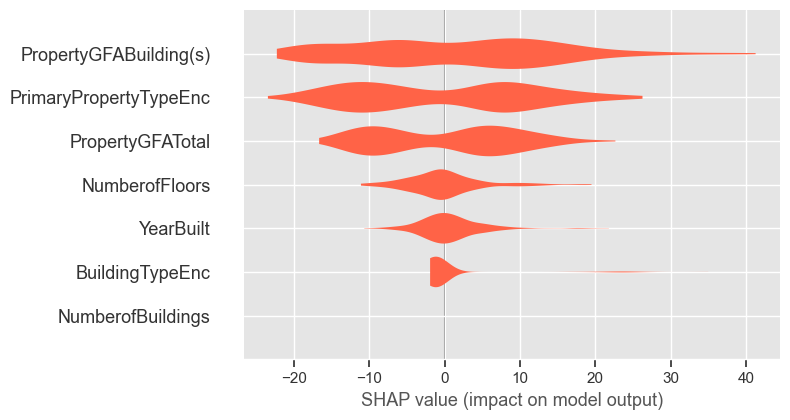

In [141]:
# Type de graphique en violon
shap.summary_plot(shap_values,
                  feature_names=X3.columns.tolist(),
                  plot_type="violin",
                  color="tomato")

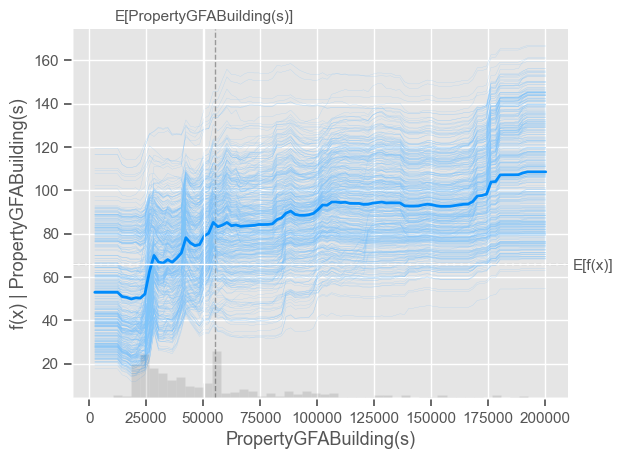

In [142]:
# graphique de dépendance partielle
shap.partial_dependence_plot("PropertyGFABuilding(s)",
                             rf_by2.predict,
                             data=X_test3,
                             feature_names=X3.columns.tolist(),
                             model_expected_value=True,
                             feature_expected_value=True,
                             ice=True
                             )

#### On ajoute a présent la variable ENERGYSTARScore à notre modele

In [143]:
path = 'cleaned/'
filename = 'dataset_cleaned2_EnergyScore.csv'

In [144]:
data = pd.read_csv(path+filename)

In [145]:
data.head()

,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFABuilding(s),PropertyGFATotal,TotalGHGEmissions,SiteEnergyUse(kBtu),BuildingTypeEnc,PrimaryPropertyTypeEnc,ENERGYSTARScore
0,1927.00,1.00,2.72,88434.00,88434.00,249.98,7226362.50,0,2,60.00
1,1996.00,1.00,2.72,88502.00,103566.00,295.86,8387933.00,0,2,61.00
2,1969.00,1.00,2.72,55020.91,58736.08,41.92,3615949.94,0,2,43.00
3,1926.00,1.00,2.72,61320.00,61320.00,286.43,6794584.00,0,2,56.00
4,1980.00,1.00,2.72,113580.00,175580.00,41.92,14172606.00,0,2,75.00


In [146]:
# On recupère seulement les lignes qui ont un ENERGYSTARScore renseigné, pour savoir si cette variable peut avoir un impact sur le modele
data = data[data.ENERGYSTARScore.notna()]
data.shape

(984, 10)

#### Data preparation 

In [147]:
# On supprime la 2eme target, qui est la consommation d'energy
data.drop('SiteEnergyUse(kBtu)', axis = 1, inplace = True)

In [148]:
# On retire la target pour le X qui sera contenu dans Y
X5 = data.drop("TotalGHGEmissions", axis = 1) 
y5 = data["TotalGHGEmissions"]

In [149]:
# Separer le jeu de données en données d'entrainement et de test
X_train5, X_test5, y_train5, y_test5 = train_test_split(X5, y5, test_size = 0.3, random_state = 42)

#### Random forest en utilisant l'approche bayésienne

In [150]:
# Definir une fonction qui va permettre de minimiser le RMSE pour l'optimisation bayésienne
def objective5(params):
    n_estimators = params[0]
    max_depth = params[1]
    min_samples_split = params[2]
    min_samples_leaf = params[3]

    randomF = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth,
                                min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf,
                                random_state=42)
    rmse = -cross_val_score(randomF, X5, y5, scoring='neg_root_mean_squared_error', cv=5).mean()
    return rmse

In [151]:
# Lancer l'optimisation bayésienne 
result3 = gp_minimize(objective5, space, n_calls=n_it, random_state=42, n_jobs=-1)

In [152]:
# Afficher les meilleurs hyperparamètres

best_n_estimators = result3.x[0]
best_max_depth = result3.x[1]
best_min_samples_split = result3.x[2]
best_min_samples_leaf = result3.x[3]
best_rmse = -result3.fun

print(f"Best n_estimators: {best_n_estimators}")
print(f"Best max_depth: {best_max_depth}")
print(f"Best min_samples_split: {best_min_samples_split}")
print(f"Best min_samples_leaf: {best_min_samples_leaf}")
print(f"Best RMSE: {best_rmse}")

Best n_estimators: 373
Best max_depth: 13
Best min_samples_split: 2
Best min_samples_leaf: 4
Best RMSE: -62.399110803553796


In [153]:
# Entraîner un random forest regressor avec les meilleurs hyperparamètre
rf9_by2 = RandomForestRegressor(n_estimators=best_n_estimators, max_depth=best_max_depth,
                            min_samples_split=best_min_samples_split, min_samples_leaf=best_min_samples_leaf,
                            random_state=42)
rf9_by2.fit(X_train5, y_train5)

y_pred9_by = rf9_by2.predict(X_test5)

In [154]:
score(y_test5, y_pred9_by)

MSE : 3899.243 || RMSE : 62.444 || MAE : 45.889 || r² : 0.105


#### Random Search

In [155]:
# On definit les paramètres  
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]

In [156]:
# On instancie notre liste de parametre
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

In [157]:
# On instancie notre random search et on l'entraine sur nos données
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
rf_random.fit(X_train5, y_train5)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [158]:
# Affichage des hyperparametres optimaux
best_params = rf_random.best_params_
best_params

{'n_estimators': 1600,
 'min_samples_split': 2,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 100}

In [159]:
# On instancie le random forest avec les meilleurs parametres puis on entraine nos données avec ce modele
rf9_random = RandomForestRegressor(**best_params)
rf9_random.fit(X_train5, y_train5)
y_pred9_random = rf9_random.predict(X_test5)

In [160]:
score(y_test5, y_pred9_random)

MSE : 3720.649 || RMSE : 60.997 || MAE : 44.862 || r² : 0.146


On observe de meilleurs performances avec le random search.

   Feature Importance            Feature Name
3                0.22  PropertyGFABuilding(s)
4                0.20        PropertyGFATotal
7                0.18         ENERGYSTARScore
6                0.16  PrimaryPropertyTypeEnc
0                0.16               YearBuilt
2                0.08          NumberofFloors
5                0.00         BuildingTypeEnc
1                0.00       NumberofBuildings


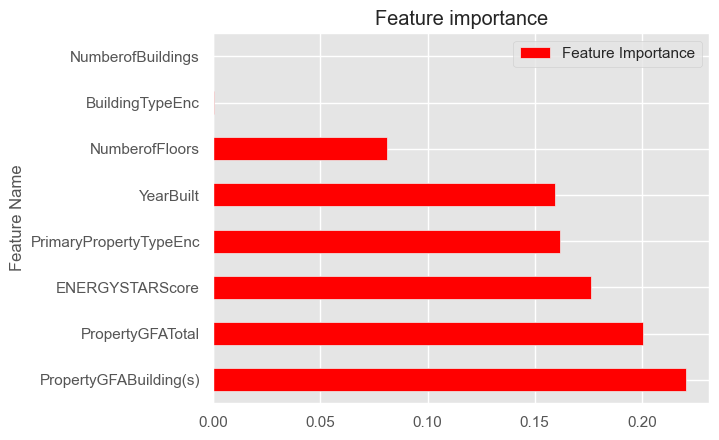

In [161]:
display_feat_imp_rforest(rf9_random, X_train5)

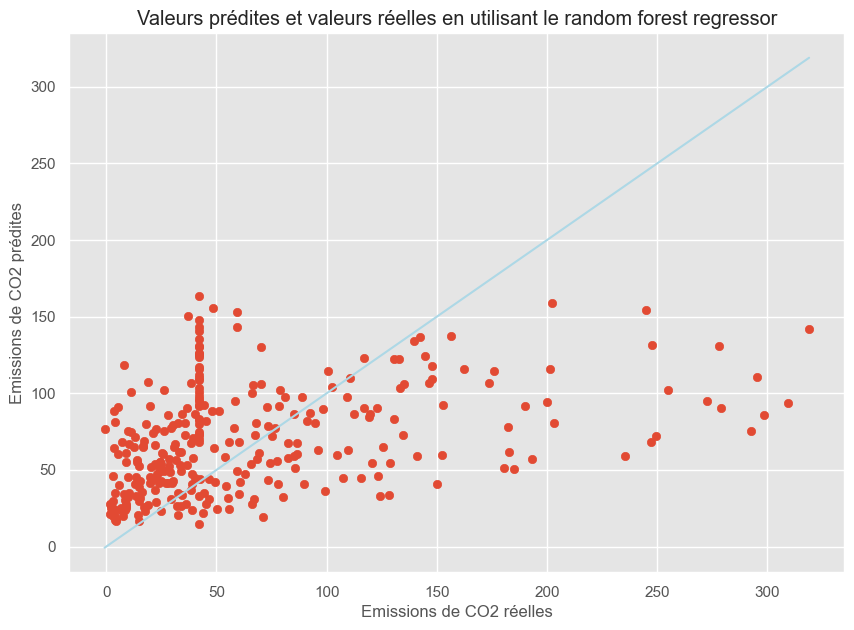

In [162]:
# Afficher les valeurs predites en comparaison avec les valeurs réelles 
plt.style.use('ggplot')
plt.figure(figsize=(10, 7))
plt.scatter(y_test5,y_pred9_random)
plt.plot([np.min(y_test5), np.max(y_test5)], [np.min(y_test5), np.max(y_test5)], color='lightblue')
plt.xlabel("Emissions de CO2 réelles")
plt.ylabel("Emissions de CO2 prédites")
plt.title("Valeurs prédites et valeurs réelles en utilisant le random forest regressor")
plt.show()

#### Sans la variable ENERGYSTARScore 

In [163]:
X6 = X5.drop('ENERGYSTARScore', axis = 1)
y6 = y5

In [164]:
X_train6 = X_train5.drop('ENERGYSTARScore', axis = 1)
X_test6 = X_test5.drop('ENERGYSTARScore', axis = 1)

##### Random forest en utilisant l'approche bayésienne

In [165]:
# Definir une fonction qui va permettre de minimiser le RMSE pour l'optimisation bayésienne
def objective6(params):
    n_estimators = params[0]
    max_depth = params[1]
    min_samples_split = params[2]
    min_samples_leaf = params[3]

    randomF = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth,
                                min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf,
                                random_state=42)
    
    rmse = -cross_val_score(randomF, X6, y6, scoring='neg_root_mean_squared_error', cv=5).mean()

    return rmse

In [166]:
# Lancer l'optimisation bayésienne 
result4 = gp_minimize(objective6, space, n_calls=n_it, random_state=42, n_jobs=-1)

In [167]:
# Afficher les meilleurs hyperparamètres
best_n_estimators = result4.x[0]
best_max_depth = result4.x[1]
best_min_samples_split = result4.x[2]
best_min_samples_leaf = result4.x[3]
best_rmse = -result4.fun

print(f"Best n_estimators: {best_n_estimators}")
print(f"Best max_depth: {best_max_depth}")
print(f"Best min_samples_split: {best_min_samples_split}")
print(f"Best min_samples_leaf: {best_min_samples_leaf}")
print(f"Best RMSE: {best_rmse}")

Best n_estimators: 500
Best max_depth: 16
Best min_samples_split: 12
Best min_samples_leaf: 4
Best RMSE: -63.12203684870751


In [168]:
# Entraîner un random forest regressor avec les meilleurs hyperparamètre
rf10_by2 = RandomForestRegressor(n_estimators=best_n_estimators, max_depth=best_max_depth,
                            min_samples_split=best_min_samples_split, min_samples_leaf=best_min_samples_leaf,
                            random_state=42)

rf10_by2.fit(X_train6, y_train5)

y_pred10_by = rf10_by2.predict(X_test6)

In [169]:
score(y_test5, y_pred10_by)

MSE : 3949.596 || RMSE : 62.846 || MAE : 45.923 || r² : 0.093


#### Random search

In [170]:
# On definit les paramètres  
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]

In [171]:
# On instancie notre liste de parametre
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

In [172]:
# On instancie notre random search et on l'entraine sur nos données
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
rf_random.fit(X_train6, y_train5)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [173]:
# Affichage des hyperparametres optimaux
best_params = rf_random.best_params_
best_params

{'n_estimators': 200,
 'min_samples_split': 10,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 40}

In [174]:
# On instancie le random forest avec les meilleurs parametres puis on entraine nos données avec ce modele
rf10_random = RandomForestRegressor(**best_params)
rf10_random.fit(X_train6, y_train5)
y_pred10_random = rf10_random.predict(X_test6)

In [175]:
score(y_test5, y_pred10_random)

MSE : 3793.585 || RMSE : 61.592 || MAE : 44.99 || r² : 0.129


On observe de meilleurs résultats avec le random search

   Feature Importance            Feature Name
3                0.26  PropertyGFABuilding(s)
4                0.23        PropertyGFATotal
0                0.21               YearBuilt
6                0.20  PrimaryPropertyTypeEnc
2                0.09          NumberofFloors
5                0.00         BuildingTypeEnc
1                0.00       NumberofBuildings


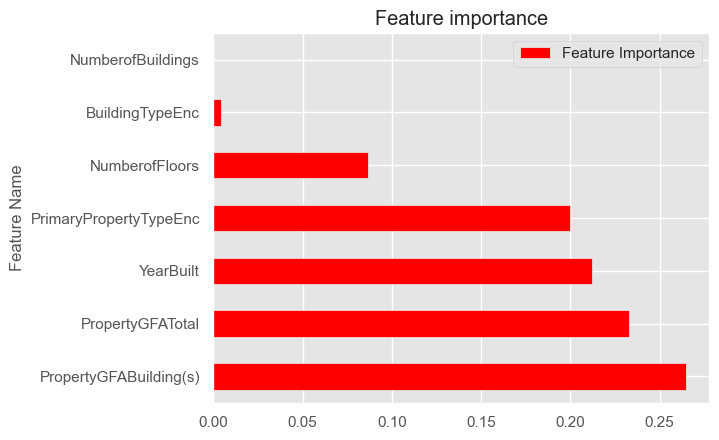

In [176]:
display_feat_imp_rforest(rf10_random, X_train6)

On remarque que la variable **ENERGYSTARScore** permet d'**améliorer les performances de notre modèle** car elle a une grande importance dans le modele mais surtout car sa présence permet d'améliorer les performances si on compare à un modele qui ne contient pas cette variable : les métriques choisies sont meilleures.  
On parle du cas de l'étude des **émissions de CO2**.